### Задание 1: 
### Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками. Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока). Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

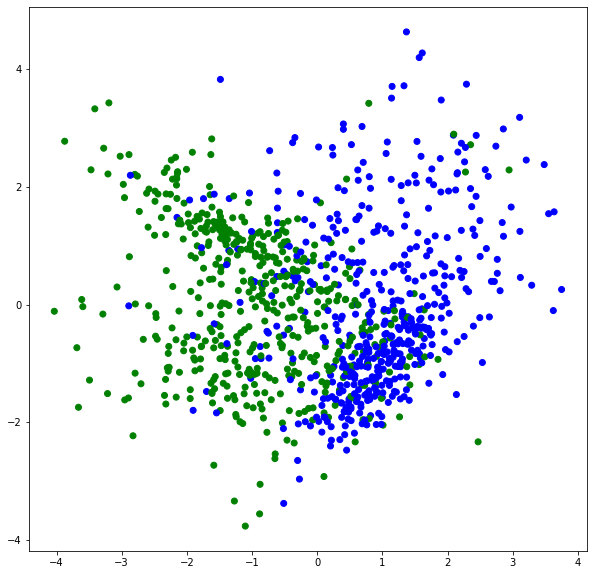

In [3]:
сolors = ListedColormap(['green', 'blue'])
light_colors = ListedColormap(['lightgreen', 'lightblue'])

plt.figure(figsize=(10,10))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=сolors);

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [6]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  
        self.t = t  
        self.true_branch = true_branch  
        self.false_branch = false_branch 

In [7]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1   
        prediction = max(classes, key=classes.get)
        return prediction      

In [8]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
def quality(left_labels, right_labels, current_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
def find_best_split(data, labels):
    
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)

            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
def tree_vote(forest, data):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    predictions_per_object = list(zip(*predictions))

    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X,y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [18]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [21]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def n_trees_plot(n_trees):

  my_forest = random_forest(train_data, train_labels, n_trees)
  train_answers = tree_vote(my_forest, train_data)
  test_answers = tree_vote(my_forest, test_data)
  train_accuracy = accuracy_metric(train_labels, train_answers)
  test_accuracy = accuracy_metric(test_labels, test_answers)


  plt.figure(figsize = (14, 6))
  colors = ListedColormap(['green', 'blue'])
  light_colors = ListedColormap(['lightgreen', 'lightblue'])

  # график обучающей выборки
  xx, yy = get_meshgrid(train_data)
  mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

  plt.subplot(1,2,1)
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
  plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
  plt.title(f'Точность случайного леса из {n_trees} деревьев на train: {train_accuracy:.3f}')

  # # график тестовой выборки
  plt.subplot(1,2,2)
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
  plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
  plt.title(f'Точность случайного леса из {n_trees} деревьев на test: {test_accuracy:.3f}')

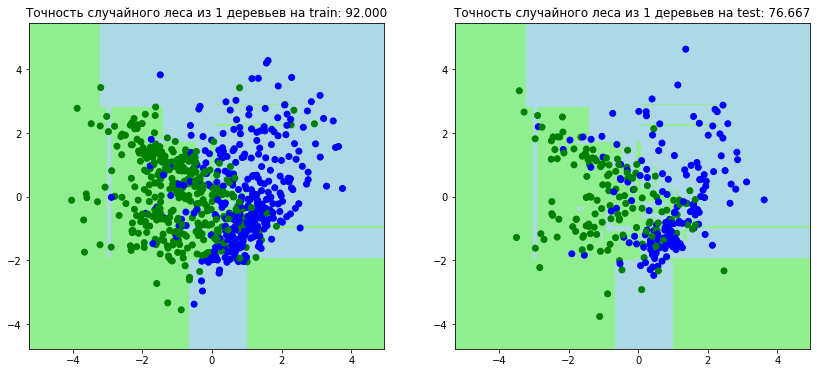

In [22]:
n_trees_plot(1)

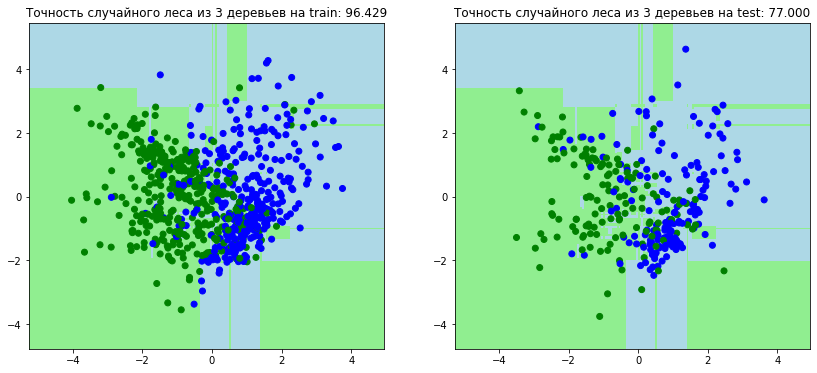

In [23]:
n_trees_plot(3)

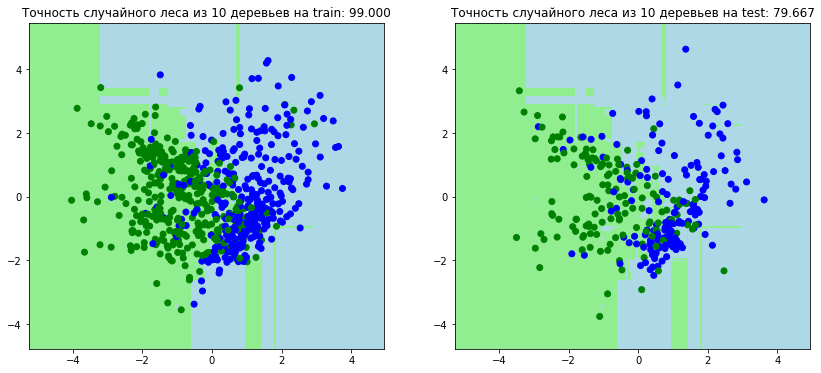

In [24]:
n_trees_plot(10)

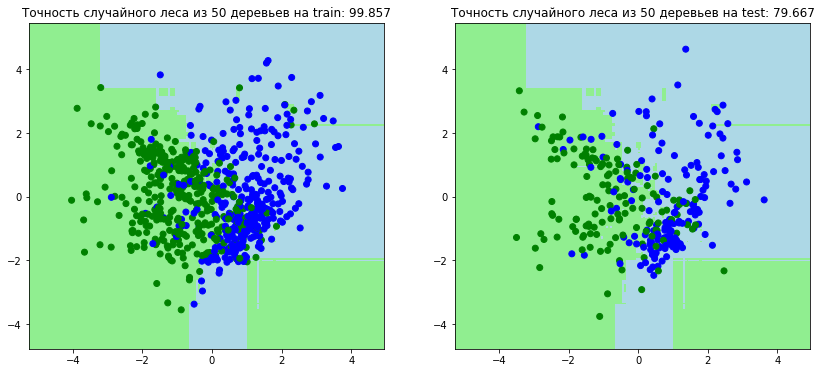

In [25]:
n_trees_plot(50)

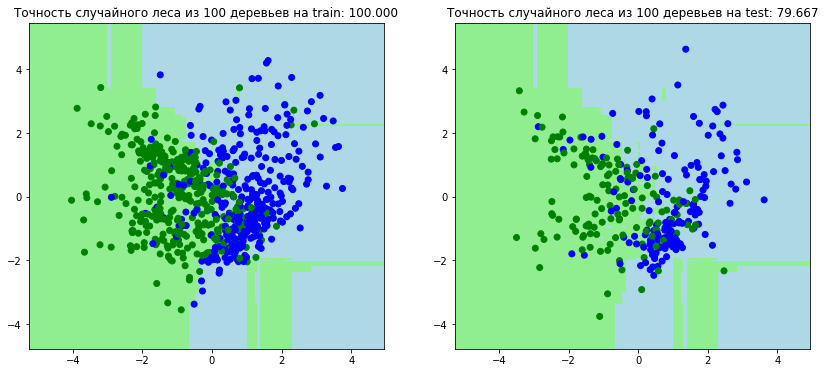

In [26]:
n_trees_plot(100)

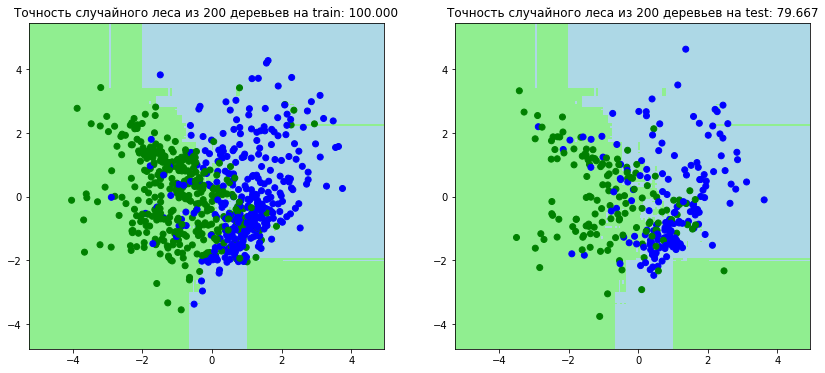

In [27]:
n_trees_plot(200)

Модель переобучилась при увеличении количества деревьев до $100.$ 
Гиперплоскость хорошо подстраивается под данные при увеличении количествава деревьев.